In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json 
import math 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer   
import textwrap
import seaborn as sns

In [82]:
model_column = 'sentence-transformers/all-mpnet-base-v2'
model_name = "all-mpnet-base-v2"
outdated_models = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'Qwen/Qwen3-Embedding-0.6B']

In [83]:
df = pd.read_parquet('data/speech_embeddings.parquet')

In [84]:
# delete all columns of outdated models
for outdated_model in outdated_models:
    if outdated_model in df.columns:
        del df[outdated_model]

In [85]:
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,multispeaker,link,translatedText,translationSource,year,block,party,migration_prob,sentence-transformers/all-mpnet-base-v2,google/embeddinggemma-300m
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, thank you very much to the Commi...",original_gm,2024,liberal,ELDR/ALDE/Renew,0.393282,"[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.06368264, -0.01790871, 0.008169121, 0.0173..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, Commissioner. People who flee wa...",original_gm,2024,green,Greens/EFA,0.423501,"[0.050362997, 0.031640317, 0.0033627285, 0.010...","[-0.06358229, 0.05332363, -0.006831329, 0.0041..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, in 2024, human trafficking co...",machine_gm,2024,left,NGL/The Left,0.375925,"[-0.016886365, 0.02107416, 0.022850083, -0.003...","[-0.049918693, -0.001202861, -0.008896867, -0...."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam Commissioner! We need very specific, ver...",machine_gm,2024,(extreme)_right,ECR,0.256493,"[0.0069901105, -0.003832352, 0.014021035, 0.03...","[-0.035047594, 0.03835739, -0.051198084, 0.050..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, thank you, Mr Engerer, becaus...",machine_gm,2024,(extreme)_right,ECR,0.475315,"[0.05082612, -0.035786744, 0.014009577, 0.0413...","[-0.06766452, 0.015919995, -0.019874139, -0.01..."


In [86]:
queries = ["Many immigrants are terrorists",
           "Immigration is a threat to the European way of life",
           "Immigrants are prone to committing crimes",
           "Arabs and/or Muslims are a cultural/social threat",
           "There are too many immigrants coming",
           "Immigration is bad"]
model = SentenceTransformer(model_name)

In [87]:
# embed queries
query_embeddings = model.encode_query(queries)

In [88]:
# compute cosine similarity between query embeddings and speech embeddings
for i, query_embedding in enumerate(query_embeddings):
    column_name = queries[i]
    df[column_name] = df[model_column].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

In [89]:
def top_speeches(df, query, n=5):
    top = df.nlargest(n, query)
    print(f"Top {n} speeches for query: '{query}'")
    for _, row in top.iterrows():
        print(f"{row['speaker']}  (sim={row[query]:.4f})")
        print(textwrap.fill(row['translatedText'], width=90))
        print()
    print("--------------------------------------------------\n")

In [90]:
for query in queries:
    top_speeches(df, query, n=5)

Top 5 speeches for query: 'Many immigrants are terrorists'
Mike Hookem  (sim=0.5364)
Mr President, we have heard much in this Chamber about how the terror attacks have nothing
to do with the open-door policy EU leaders foisted upon Members, which saw migrants claim
refugee status they were not entitled to. Daesh boasted they would flood our continent
with jihad fighters, although Members here in the Chamber derided those of us who pointed
this out. We know that two of the murderers involved in the Paris killings came to the
continent via Greece, using false Syrian passports. What is this if it is not a direct
link between uncontrolled immigration and terrorism? I reject this idea put forward by
people like President Juncker that terrorism is a risk we must live with to uphold the
EU’s ideals of freedom of movement. The migrant crisis has put the well-being of migrants
ahead of the safety of its citizens by making us vulnerable to attack in our towns and
cities. Come the UK’s referendum

In [91]:
# aggregate over parties and years: compute mean similarity per query and number of speeches
agg = (
    df
    .groupby(["block", "year"])
    .agg({q: "mean" for q in queries})
    .reset_index()
)

# add number of speeches per group
counts = df.groupby(["block", "year"]).size().reset_index(name="n_speeches")
agg = agg.merge(counts, on=["block", "year"])

## Plot cosine similarities for every party over time

In [92]:
with open('plotting_parameters/color_maps/color_map_block.json') as f:
    color_map = json.load(f)

In [93]:
def plot_mean_similarity_by_party(agg, query):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=agg, x='year', y=query, hue='block', marker='o', palette=color_map)
    plt.title(f"Mean Similarity for Query: '{query}' by Party Block Over Years")
    plt.ylabel("Mean Cosine Similarity")
    plt.xlabel("Year")
    plt.legend(title='Party Block')
    plt.grid(True)
    plt.show()

In [94]:
def plot_ratio_of_very_similar_speeches(df, query, percentile=90):
    threshold = np.percentile(df[query], percentile)
    print(f"Threshold for {percentile}th percentile for query '{query}': {threshold:.4f}")

    agg_percentile = (
        df
        .assign(above_percentile=lambda x: x[query] > threshold)
        .groupby(["block", "year"])
        .agg(n_speeches_above_percentile=("above_percentile", "sum"), n_speeches=(query, "size"))
        .reset_index()
    )

    print(agg_percentile.head())

    # normalize by total speeches in each year
    agg_percentile["ratio_above_percentile"] = (
        agg_percentile["n_speeches_above_percentile"] / agg_percentile["n_speeches"]
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=agg_percentile, x='year', y='ratio_above_percentile', hue='block', marker='o', palette=color_map)
    plt.title(f"Number of Speeches with Similarity in {percentile}th Percentile for Query: '{query}' by Party Block Over Years")
    plt.ylabel("Number of Speeches")
    plt.xlabel("Year")
    plt.legend(title='Party Block')
    plt.grid(True)
    plt.show()

Threshold for 90th percentile for query 'Many immigrants are terrorists': 0.3455
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            7          46
1  (extreme)_right  2015                           78         624
2  (extreme)_right  2016                          118        1023
3  (extreme)_right  2017                           19         189
4  (extreme)_right  2018                           17         150


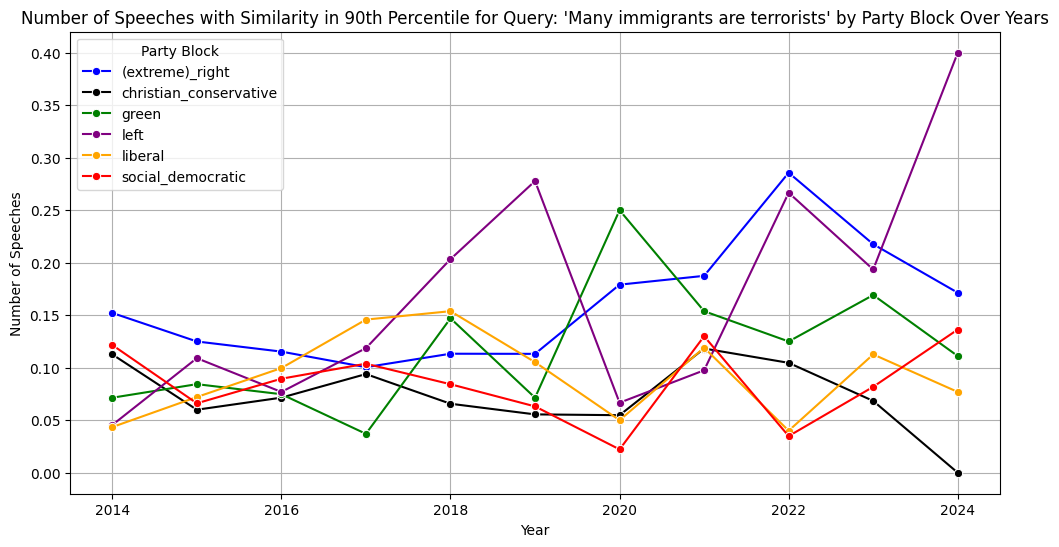

Threshold for 90th percentile for query 'Immigration is a threat to the European way of life': 0.5726
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            3          46
1  (extreme)_right  2015                           87         624
2  (extreme)_right  2016                          133        1023
3  (extreme)_right  2017                           21         189
4  (extreme)_right  2018                           17         150


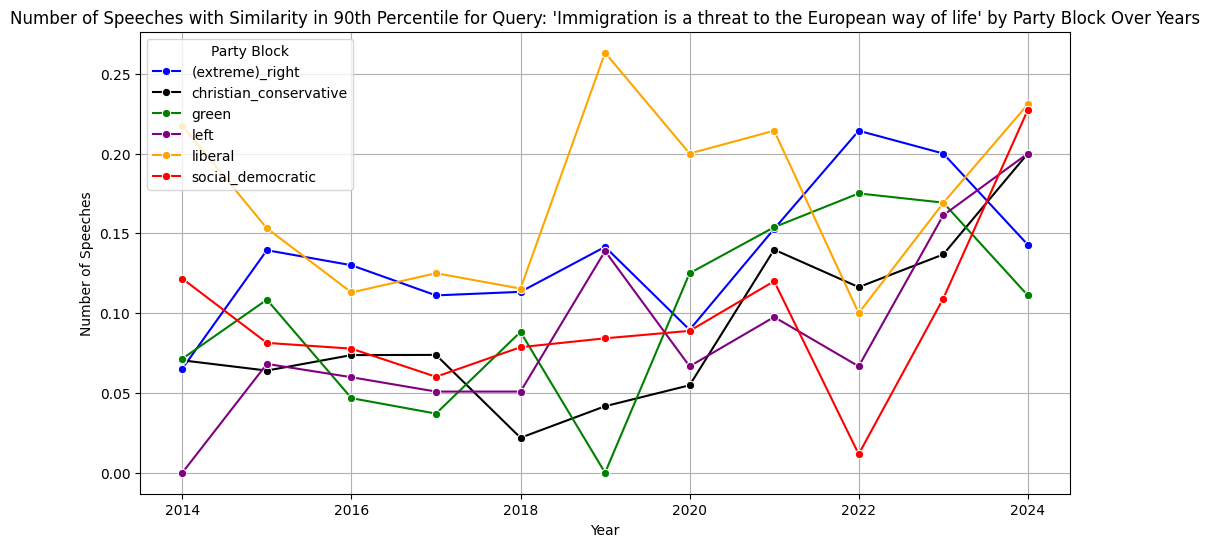

Threshold for 90th percentile for query 'Immigrants are prone to committing crimes': 0.3623
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            7          46
1  (extreme)_right  2015                           71         624
2  (extreme)_right  2016                          127        1023
3  (extreme)_right  2017                           24         189
4  (extreme)_right  2018                           19         150


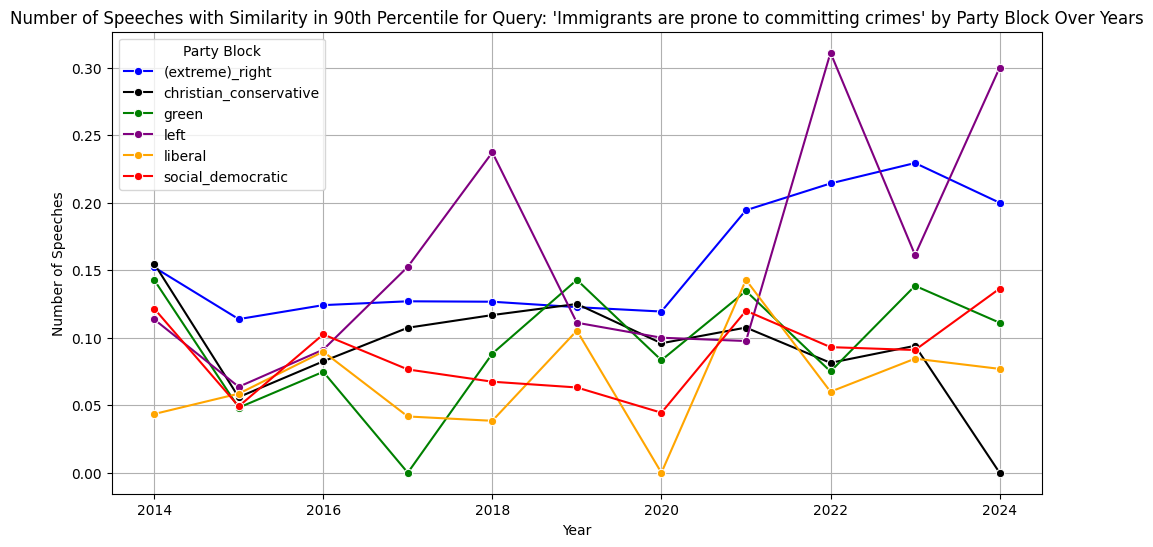

Threshold for 90th percentile for query 'Arabs and/or Muslims are a cultural/social threat': 0.3083
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            6          46
1  (extreme)_right  2015                           64         624
2  (extreme)_right  2016                           98        1023
3  (extreme)_right  2017                           19         189
4  (extreme)_right  2018                           11         150


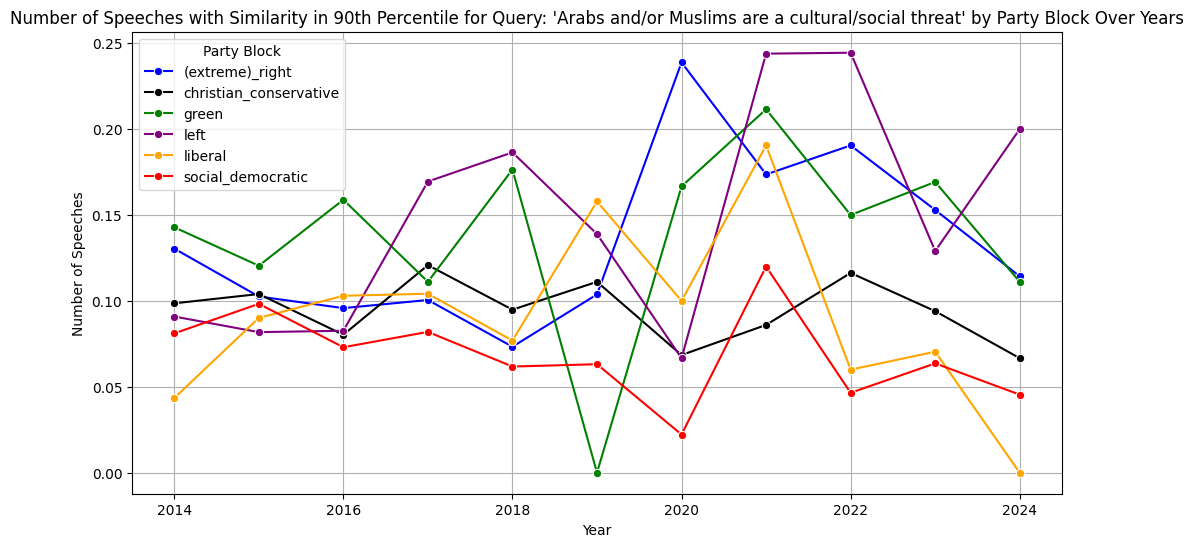

Threshold for 90th percentile for query 'There are too many immigrants coming': 0.3473
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            5          46
1  (extreme)_right  2015                           99         624
2  (extreme)_right  2016                          166        1023
3  (extreme)_right  2017                           25         189
4  (extreme)_right  2018                           25         150


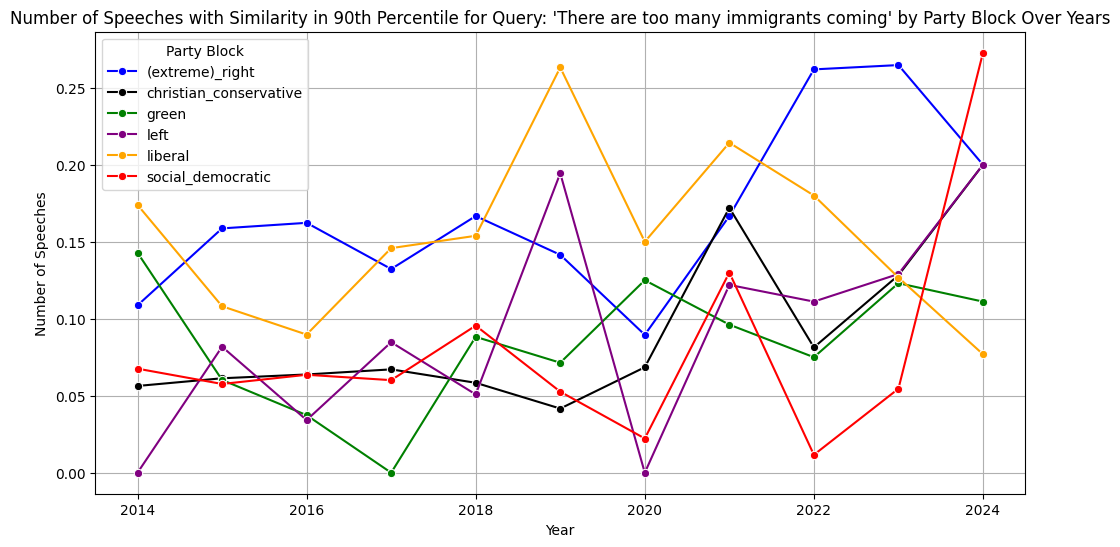

Threshold for 90th percentile for query 'Immigration is bad': 0.3567
             block  year  n_speeches_above_percentile  n_speeches
0  (extreme)_right  2014                            6          46
1  (extreme)_right  2015                           90         624
2  (extreme)_right  2016                          112        1023
3  (extreme)_right  2017                           17         189
4  (extreme)_right  2018                           20         150


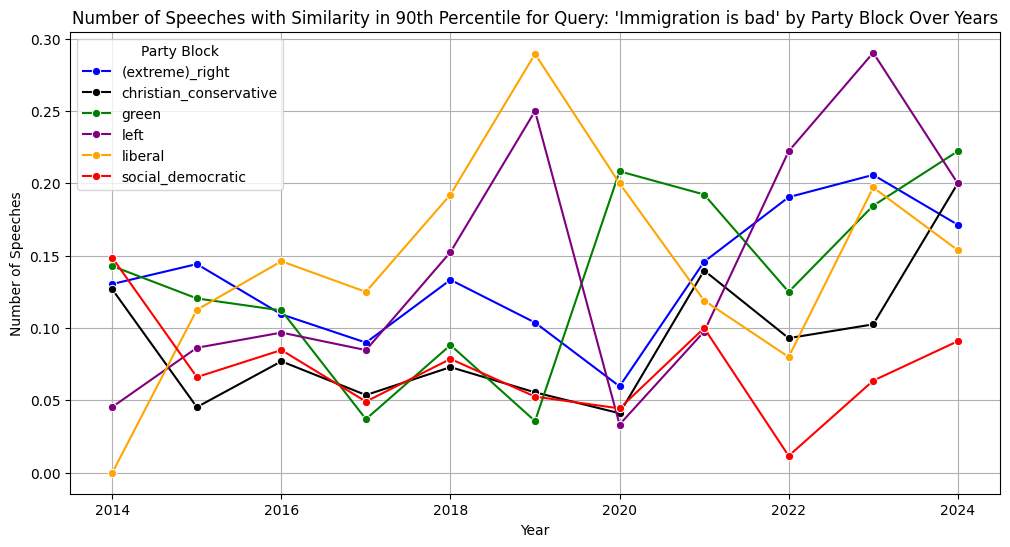

In [95]:
for query in queries:
    plot_ratio_of_very_similar_speeches(df, query)